 num_features: ['age', 'gfr'] 
 cat_features: ['sex', 'bmi', 'htn', 'dm', 'smoking', 'family history of cad', 'high cholesterol level'] 
 target(classification): ejection fraction
number of columns match number of features and target


ejection fraction
normal      0.518059
abnormal    0.481941
Name: proportion, dtype: float64

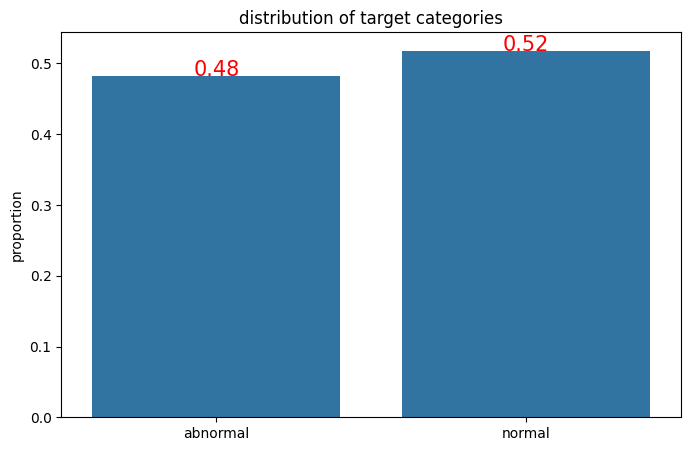

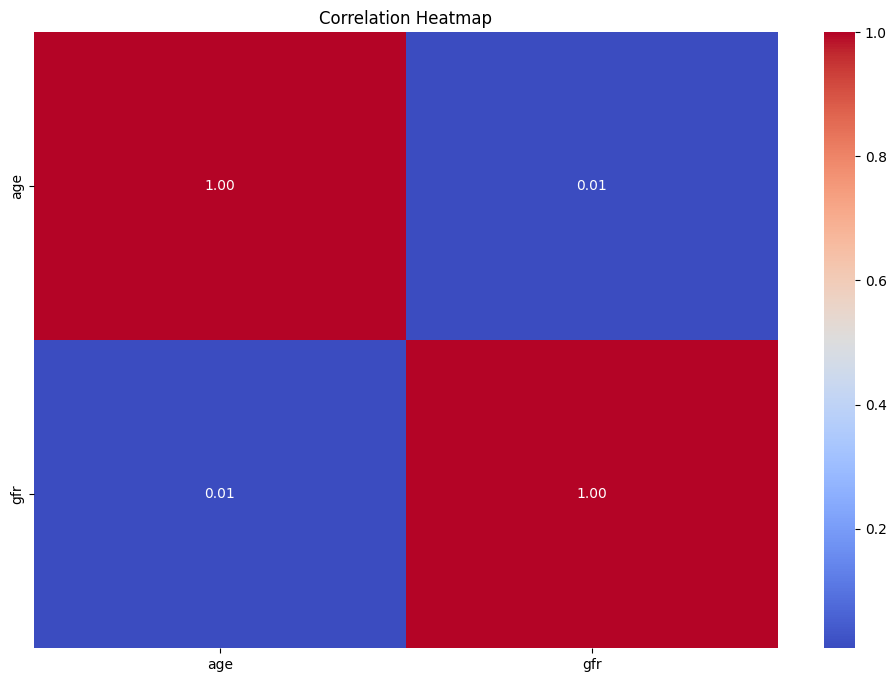

############
displaying a part of the features df and the targey series


,sex,age,bmi,htn,dm,smoking,family history of cad,high cholesterol level,gfr
0,male,51,below 30,no,no,no,no,yes,5.0
1,female,62,below 30,yes,yes,no,no,yes,7.0


pandas.core.frame.DataFrame

0    normal
1    normal
Name: ejection fraction, dtype: category
Categories (2, object): ['abnormal' < 'normal']

pandas.core.series.Series

In [48]:
def split_features_target(df,target,print_check=False,object_as_cat=True,target_distribution=False,plot_target_distribution=False,heatmap_num=False,
                                                                                                          distr_figsize=(8,5),heatmap_figsize=(12,8)):
    '''
    *this functions returns x,y(target) of a df
    and by choice(use the 3rd arg.) checks whether the number of features and the target match the number of cols in the df*
    args:
    1-df
    2-target(str)
    3-print_check[boolean](def is False):activate by choice
    4-object_as_cat[boolean](def is True):Convert all object dtype columns to 'category'(
    **keep it True only do this if the values stored in such object cols can be converted to categories)**
      Returns:
    x (DataFrame): Feature columns.
    y (pd.Series): Target column.
    '''
    if object_as_cat==True:# Convert all object dtype columns to 'category'(only do this if the values stored in such object cols can be converted to categories)
        df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype('category')
    ###
    x=df.drop(target,axis=1)
    y=df[target]
    ##
    num_df=x.select_dtypes(include=np.number)#df
    num_features=list(num_df.columns)#list of df.columns
    ##
    cat_df=x.select_dtypes(exclude=np.number)#df
    cat_features=list(cat_df.columns)#list of df.columns
    ###
    if print_check==True:
        print(" num_features:",num_features,"\n","cat_features:",cat_features,"\n","target(classification):",y.name)
        if (len(df.columns)==(len(num_features)+len(cat_features)+1))==True:#+1 >>>for target
            print("number of columns match number of features and target")
        else:
            print("number of columns dont match number of features and target")
    ###
    if target_distribution:
        display(y.value_counts(normalize=1))
    if plot_target_distribution:
        plt.figure(figsize=distr_figsize)#default is (7,5) in the argumets of the function
        categories=y.unique()
        propotion=y.value_counts(normalize=1)
        sns.barplot(x=categories,y=propotion)
        for cat,value in zip(categories,propotion):
            plt.text(cat,value,f'{value:.2f}',ha='center',fontsize=15,color='red')
        plt.title('distribution of target categories')
        plt.show()
    ###
    corr_matrix = num_df.corr()
    # display(corr_matrix)
    if heatmap_num:
        
        plt.figure(figsize=heatmap_figsize)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Heatmap')
        plt.show()

        
        
    ###
    return x,y

###
x,y=split_features_target(df,'ejection fraction',print_check=1,object_as_cat=True,target_distribution=True,plot_target_distribution=True,heatmap_num=True) # u dont need to write True or False>>just writ 1 or 0 with the corrct order of arguments of boolean type
print('############')
print('displaying a part of the features df and the targey series')
display(x.head(2),type(x),y.head(2),type(y))

In [50]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
La_encoder=LabelEncoder()
oh_encoder = OneHotEncoder(sparse_output=False)#u may use drop="first" like in get_dummies arg.>>drop_first=True
scaler=StandardScaler()
x,y=split_features_target(df,'ejection fraction',0,object_as_cat=True)
def splitting_train_test(x, y,encode_x=False,cat_x_encoding='onehot',encoding_map=None,ordinal_orders=None,scaling =False,poly_features=False,poly_degree=2,output_x_numpy=True,y_encoding='label',y_order=None):
    """
    *This function is for preprocessing  classification target dataset*
    Args:
    1-x ( pd.DataFrame): Feature dataframe.(we will return it after split  as numpy.ndarray or as df [so that we can retain column names and indices for train,test datasets])
    2-y (pd.Series or np.array): Target variable (binary or multi-claas classification)(should be 1d array to be suitable for ML models.(use label or ordinal encoding or mapping)
    3-encode_x (bool)*[default is False]*: Whether to encode categorical features in x.(for most ML models u should encode features into numbers except:cat_boost for eg.)
    4-cat_x_encoding (str)[default is 'onehot']: Encoding type for categorical features. Choose from 'onehot', 'label', or 'ordinal'or'mixed'.
    5-encoding_map(dictionary)[default is None]:specify different encodings to differnt categorical features(dict.) 
    6-ordinal_orders(dictionary)[default is None]:specify the order of each categorical column that will have ordinal encoding applied on it
    7-scaling (bool)*[default is False]*: Whether to scale numerical features in x.
    8-poly_features(boolean):the default is False
    7-poly_degree(int)(default is 2):sets the n_degree of the ploy function if applied
    8-output_x_numpy (bool)*[def is True]*: Whether to return x_train, x_test as NumPy arrays(less computation and compatible with ML models but the drawback is the inability to retain col names,indices)
    9-y_encoding(str)(default is 'label'):choose to whether encode the target by label or ordinal encoding.
    10-y_order(default is none)(dictionary):only if u choose y_encoding to be ordinal
    **Returns:**
        tuple:1,2- Processed (x_train, x_test) as numpy arrays or dfs ,u choose to return them with encoding/scaling or both or none.
              3,4-, y_train, y_test as 1d numpy.arrays(to be suitable for most ML models)
    ***global variables from the function:y_label_mapping,y_ordinal_mapping
    ----------
    *if binary class.:we will encode the whole y to zeroes and ones(binary classification) by label encoding or .map or .replace not one hot-encoding(as it creates col for each cat) 
    as this is needed for most ML class. models(need y as 1d array or pd.series)
    and this wont lead to data leakage as it is independant on the features.*
    ***we can encode y or just manualluy use .map or .replace...***
    -no data leakage as:
    **the models train on the features(x) not the target(y)**
    *in this function we will return the x(train,test) as numpy.ndarray or dfs and y(train,test) as numpy array(use df.values)*
    """
    # Validate inputs
    if not isinstance(x, pd.DataFrame):
        raise ValueError("Input x must be a pandas DataFrame.")
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise ValueError("Input y must be a pandas Series or numpy array ")
    if len(np.unique(y)) < 2:
        raise ValueError("classification Target categories (y) must be at least 2")
    # Ensure poly_degree is valid
    if not isinstance(poly_degree, int) or poly_degree < 1:
        raise ValueError("poly_degree must be an integer >= 1.")
    ########
    #encoding the target (y)
    if y_encoding=='label':
        #encode the target to 0s and ones and...
        Le_encoder=LabelEncoder()
        y_encoded=Le_encoder.fit_transform(y).flatten() # Flatten back to 1D array,##make sure to use this encoded y in future preprocessing
        # Get the mapping of categories to numbers
        global y_label_mapping
        y_label_mapping = {category: number for number, category in enumerate(Le_encoder.classes_)}#dict comprehension,may want to track the categories
        #y_encoded>>1d array of zeroes and ones,...
    elif y_encoding=='ordinal':
        if y_order==None:
            raise ValueError("For ordinal encoding, 'y_order' must be specified for y.")
        else:
            ordinal_encoder = OrdinalEncoder(categories=[y_order])
            y = np.array(y).reshape(-1, 1)  # Ensure y is 2D for OrdinalEncoder
            y_encoded = ordinal_encoder.fit_transform(y).flatten()  # Flatten back to 1D array
            #y_encoded>>1d array of zeroes and ones,..
            # Get the mapping of categories to numbers
            global y_ordinal_mapping
            y_ordinal_mapping = {category: number for number, category in enumerate(y_order)}
    else:
        raise ValueError("invalid value for y encoding ,choose between:'label' or 'ordinal' ")
    #  split the dataset to train,test 
    x_train,x_test,y_train,y_test=train_test_split(x,y_encoded,test_size=0.2,random_state=42,stratify=y_encoded)####y_encoded(zeroes and 1sand...) not just y
    #u input dfs to the split ,it outputs dfs as well
    #x was df>>output of x_train,test>df
    #while y_encoded(input in the split ) is numpy array(due to .fit_transform of L_encoder),so y_train/test>>numpy.array
    ###
    #use .values to convert the dfs to raw numpy arrays if u want and concat num and cat using np.hstack or keep it as df and concat by pd.concat(axis=1(for dfs)
    #i will retain x as df to retain columns names and indices
     # Separate numerical and categorical features
    num_cols = list(x.select_dtypes(include=np.number).columns)
    cat_cols = list(x.select_dtypes(exclude=np.number).columns)
    ###
    x_train_num,x_test_num=x_train[num_cols],x_test[num_cols]#dfs
    x_train_cat,x_test_cat=x_train[cat_cols],x_test[cat_cols]#dfs
    ###
    # Generate polynomial features if enabled
    if poly_features==True:
        poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
        x_train_num_poly = poly.fit_transform(x_train_num)
        x_test_num_poly = poly.transform(x_test_num)

        # Convert back to DataFrame to retain column names
        poly_feature_names = poly.get_feature_names_out(num_cols)
        x_train_num_poly = pd.DataFrame(x_train_num_poly, columns=poly_feature_names, index=x_train.index)
        x_test_num_poly = pd.DataFrame(x_test_num_poly, columns=poly_feature_names, index=x_test.index)
    else:#if no poly is applied>>overwrite the poly objects with the dfs without poly(to use the same object name in the following lines whether u activate poly or not)
        x_train_num_poly=x_train_num
        x_test_num_poly=x_test_num
        
    #scaling the numerical features
    if scaling == True:#scaling numerial **features** only
        x_train_num_scaled=scaler.fit_transform(x_train_num_poly)
        x_test_num_scaled=scaler.transform(x_test_num_poly)
        #.transform() mostly returns  numpy arrays
        #convert them backk to dfs to retain columns and indices as .transform() mostly returns numpy arrayss
        x_train_num_scaled = pd.DataFrame(x_train_num_scaled, columns=num_cols, index=x_train.index)#df
        x_test_num_scaled = pd.DataFrame(x_test_num_scaled, columns=num_cols, index=x_test.index)#df
    else:#if no scaling is applied(overwrite it with object of the last step(poly) and the poly maybe activated or overwritten by x_train without poly)
        x_train_num_scaled=x_train_num_poly #df
        x_test_num_scaled=x_test_num_poly #df
    
    ##########
    
    # Encoding the categorical features
    if encode_x==True:#its else statement in line 161
        if cat_x_encoding in ["onehot", "label", "ordinal"]:#its else statement in line 159
            # Apply the same encoding to all categorical columns
            if cat_x_encoding == "onehot":
                x_train_cat_encoded = oh_encoder.fit_transform(x_train_cat)
                x_test_cat_encoded = oh_encoder.transform(x_test_cat)
                # Convert back to DataFrame to retain column names and indices(if needed)
                encoded_cat_columns = oh_encoder.get_feature_names_out(cat_cols)#retain the new cols made by one hot encoding
                x_train_cat_encoded = pd.DataFrame(x_train_cat_encoded, columns=encoded_cat_columns, index=x_train.index)
                x_test_cat_encoded = pd.DataFrame(x_test_cat_encoded, columns=encoded_cat_columns, index=x_test.index)
            
            elif cat_x_encoding == "label":
                x_train_cat_encoded = pd.DataFrame(index=x_train_cat.index)#as an empty df to store the encoded values with same num_rows as the org. df of features
                x_test_cat_encoded = pd.DataFrame(index=x_test_cat.index)#as an empty df to store the encoded values with same num_rows as the org. df of features
                for col in cat_cols:
                    le = LabelEncoder()
                    x_train_cat_encoded[col] = le.fit_transform(x_train_cat[col])#fill the emty column of the df with the encoded values
                    x_test_cat_encoded[col] = le.transform(x_test_cat[col])#fill the emty column of the df with the encoded values
            
            elif cat_x_encoding == "ordinal":
                if ordinal_orders==None:
                    raise ValueError("For ordinal encoding, 'ordinal_orders' must be specified.")
                ordinal_encoder = OrdinalEncoder(categories=[ordinal_orders[col] for col in cat_cols])
                x_train_cat_encoded = pd.DataFrame(
                    ordinal_encoder.fit_transform(x_train_cat), columns=cat_cols, index=x_train.index
                )
                x_test_cat_encoded = pd.DataFrame(
                    ordinal_encoder.transform(x_test_cat), columns=cat_cols, index=x_test.index
                )
        
        elif cat_x_encoding == "mixed":
            # Mixed encoding: column-wise specific encodings
            if encoding_map==None:
                raise ValueError("For 'mixed' encoding, 'encoding_map' must be specified as a dictionary.")
            x_train_cat_encoded = pd.DataFrame(index=x_train.index)#as an empty df to store the encoded values with same num_rows as the org. df of features
            x_test_cat_encoded = pd.DataFrame(index=x_test.index)#as an empty df to store the encoded values with same num_rows as the org. df of features
            for col, encoding_type in encoding_map.items():
                if encoding_type == "onehot":#each category will be converted to a colum(one cat_col give multiple cols)
                    onehot_encoded_train = oh_encoder.fit_transform(x_train[[col]])
                    onehot_encoded_test = oh_encoder.transform(x_test[[col]])
                    onehot_columns = oh_encoder.get_feature_names_out([col])#retain the new cols made by one hot encoding
                    onehot_train_df = pd.DataFrame(onehot_encoded_train, columns=onehot_columns, index=x_train.index)
                    onehot_test_df = pd.DataFrame(onehot_encoded_test, columns=onehot_columns, index=x_test.index)
                    x_train_cat_encoded = pd.concat([x_train_cat_encoded, onehot_train_df], axis=1)#concat the new cols from each category to the empty df
                    x_test_cat_encoded = pd.concat([x_test_cat_encoded, onehot_test_df], axis=1)
                
                elif encoding_type == "label":
                    le = LabelEncoder()
                    x_train_cat_encoded[col] = le.fit_transform(x_train_cat[col])#fill the emty column of the df with the encoded values
                    x_test_cat_encoded[col] = le.transform(x_test_cat[col])
                
                elif encoding_type == "ordinal":
                    if col not in ordinal_orders:
                        raise ValueError(f"Order for ordinal encoding of column '{col}' must be specified in 'ordinal_orders'.")
                    ordinal_encoder = OrdinalEncoder(categories=[ordinal_orders[col]])
                    x_train_cat_encoded[col] = ordinal_encoder.fit_transform(x_train[[col]]).flatten()#Flatten back to 1D array as ordinal encoding input and output is 2d 
                    x_test_cat_encoded[col] = ordinal_encoder.transform(x_test[[col]]).flatten()# Flatten back to 1D array
                
                else:
                    raise ValueError(f"Invalid encoding type '{encoding_type}' for column '{col}'. Choose from 'onehot', 'label', or 'ordinal'.")
        else:
            raise ValueError("Invalid value for 'cat_x_encoding'. Choose from 'onehot', 'label', 'ordinal', or 'mixed'.")
    else:#(no encoding features) overwriting if encoding features isnt applied
        x_train_cat_encoded = x_train_cat  # No encoding
        x_test_cat_encoded = x_test_cat  # No encoding

    
   
        
    ##the (scaled,unscaled) features and (encoded,unencoded) features must have had the same object name assigned so that it is consistent when we concat     
    #concatenate numerical and categorical >>>>>edit later>>concat need df not np arrrays or u can use hstack
    x_train_processed=pd.concat([x_train_cat_encoded,x_train_num_scaled],axis=1)#dont forget axis=1
    x_test_processed=pd.concat([x_test_cat_encoded,x_test_num_scaled],axis=1)#dont forget axis=1
    #x_train,x_test may undergo preproccessing(u choose in the argument of the functions)so we need to reassigne them
    #while y_train,y_test are the split of the encoded y at the beginning
    if output_x_numpy==True:#.values convert the df to raw numpy array output(less computation but the drawback is the inability to retain col names,indices)
        x_train_processed = x_train_processed.values
        x_test_processed = x_test_processed.values
        
    return x_train_processed, x_test_processed, y_train, y_test

In [52]:
#do this before each model and choose with the args whether to encode/scale ,both or none cat_features
x_train,x_test,y_train,y_test=splitting_train_test(x, y, encode_x=False, scaling =False)
print(x_train.shape,x_test.shape)#2d numpy arrays
print(y_train.shape,y_test.shape)#1d numpy arrays/with 1 column
print("###")
###
x_train,x_test,y_train,y_test=splitting_train_test(x, y, encode_x=False, scaling =True)#less columns in x than before as the encoding used was one-hot encoding
print(x_train.shape,x_test.shape)#2d numpy arrays
print(y_train.shape,y_test.shape)#1d numpy arrays/with 1 column
print("###")
#######
x_train,x_test,y_train,y_test=splitting_train_test(x, y, encode_x=True, scaling =False)
print(x_train.shape,x_test.shape)#2d numpy arrays
print(y_train.shape,y_test.shape)#1d numpy arrays/with 1 column
print("###")
###
x_train,x_test,y_train,y_test=splitting_train_test(x, y, encode_x=True, scaling =True)#encoding(one-hot encoding adds columns acc. to num_categories,scaling the features(x)
print(x_train.shape,x_test.shape)#2d numpy arrays
print(y_train.shape,y_test.shape)#1d numpy arrays/with 1 column
print("###")

(708, 9) (178, 9)
(708,) (178,)
###
(708, 9) (178, 9)
(708,) (178,)
###
(708, 16) (178, 16)
(708,) (178,)
###
(708, 16) (178, 16)
(708,) (178,)
###


### you can apply the switching after finishing model training

In [56]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_variance_elbow(x_train, x_test, n_components=None, plot=False, interactive=False, figsize=(8, 5)):
    """
    Plot the cumulative explained variance for PCA and allow interactive or direct selection of n_components.

    Args:
        x_train (array-like): Training data.
        x_test (array-like): Testing data.
        n_components (int, optional): Number of components to use directly if interactive=False.
        interactive (bool): If True, allows interactive input after plotting the elbow curve.
        figsize (tuple): Size of the plot.

    Returns:
        x_train_pca (array): PCA-transformed training data.
        x_test_pca (array): PCA-transformed testing data.
        pca (PCA object): Fitted PCA object.
    """
    # Fit PCA on the training data
    pca = PCA().fit(x_train)
    cum_sum = pca.explained_variance_ratio_.cumsum()

    # Plot cumulative explained variance if plot is True
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(range(1, len(cum_sum) + 1), cum_sum, marker='o', linestyle='--')
        plt.xticks(range(1, len(cum_sum) + 1))
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Cumulative Explained Variance")
        plt.grid()
        plt.show()

    # Interactive mode: user chooses the number of components based on the elbow
    if interactive:
        while True:
            try:
                n_components = int(input(f"Choose the number of components based on the elbow (1 to {len(cum_sum)}): "))
                if n_components < 1 or n_components > len(cum_sum):
                    print(f"Please choose a number between 1 and {len(cum_sum)}.")
                else:
                    break
            except ValueError:
                print("Invalid input. Please enter a valid integer.")

    # If interactive=False, validate n_components
    if not interactive:
        if n_components is None or n_components < 1 or n_components > len(cum_sum):
            raise ValueError(f"Invalid value for n_components: {n_components}. Must be between 1 and {len(cum_sum)}.")

    # Apply PCA with the selected number of components
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    print(f"PCA applied with {n_components} components.")

    return x_train_pca, x_test_pca, pca, cum_sum


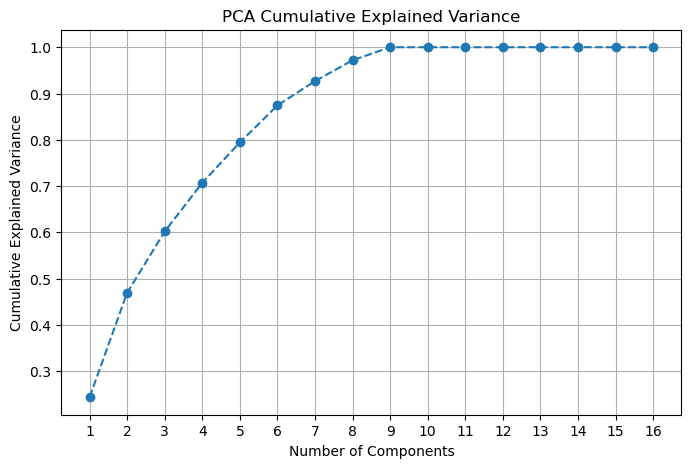

Choose the number of components based on the elbow (1 to 16):  9


PCA applied with 9 components.


In [110]:
# x_train,x_test,y_train,y_test=splitting_train_test(x, y, encode_x=True, scaling =True ,output_x_numpy=True)#encode and scale features(x)
# x_train_pca, x_test_pca, pca_nd, cum_sum=plot_pca_variance_elbow(x_train,x_test,None,1,1)

In [51]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

def plot_svd_variance_elbow(x_train, x_test, n_components=None, plot=False, interactive=False, figsize=(8, 5)):
    """
    Plot the cumulative explained variance for Truncated SVD and allow interactive or direct selection of n_components.

    Args:
        x_train (array-like): Training data.
        x_test (array-like): Testing data.
        n_components (int, optional): Number of components to use directly if interactive=False.
        interactive (bool): If True, allows interactive input after plotting the elbow curve.
        figsize (tuple): Size of the plot.

    Returns:
        x_train_svd (array): SVD-transformed training data.
        x_test_svd (array): SVD-transformed testing data.
        svd (TruncatedSVD object): Fitted TruncatedSVD object.
        cum_sum (array): Cumulative explained variance.
    """
    # Fit Truncated SVD on the training data
    svd = TruncatedSVD().fit(x_train)
    cum_sum = svd.explained_variance_ratio_.cumsum()

    # Plot cumulative explained variance if plot is True
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(range(1, len(cum_sum) + 1), cum_sum, marker='o', linestyle='--')
        plt.xticks(range(1, len(cum_sum) + 1))
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Truncated SVD Cumulative Explained Variance")
        plt.grid()
        plt.show()

    # Interactive mode: user chooses the number of components based on the elbow
    if interactive:
        while True:
            try:
                n_components = int(input(f"Choose the number of components based on the elbow (1 to {len(cum_sum)}): "))
                if n_components < 1 or n_components > len(cum_sum):
                    print(f"Please choose a number between 1 and {len(cum_sum)}.")
                else:
                    break
            except ValueError:
                print("Invalid input. Please enter a valid integer.")

    # If interactive=False, validate n_components
    if not interactive:
        if n_components is None or n_components < 1 or n_components > len(cum_sum):
            raise ValueError(f"Invalid value for n_components: {n_components}. Must be between 1 and {len(cum_sum)}.")

    # Apply Truncated SVD with the selected number of components
    svd = TruncatedSVD(n_components=n_components)
    x_train_svd = svd.fit_transform(x_train)
    x_test_svd = svd.transform(x_test)

    print(f"Truncated SVD applied with {n_components} components.")

    return x_train_svd, x_test_svd, svd, cum_sum


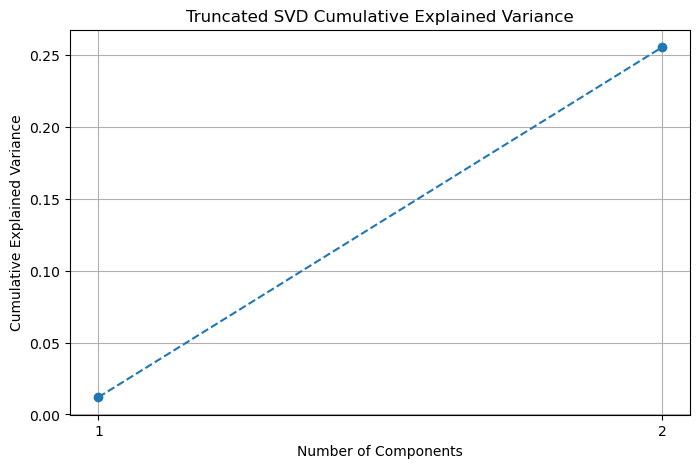

Choose the number of components based on the elbow (1 to 2):  2


Truncated SVD applied with 2 components.


(array([[ 2.06305842, -1.76375244],
        [ 1.82305776,  0.09868914],
        [ 2.33872229, -1.18895678],
        ...,
        [ 2.05717241, -1.1615745 ],
        [ 2.03901254, -0.26475033],
        [ 2.33162839,  0.18182725]]),
 array([[ 2.44495563e+00, -1.38970468e+00],
        [ 2.12482193e+00,  1.61101884e+00],
        [ 2.43519992e+00, -4.43589060e-01],
        [ 2.33384444e+00, -7.15898972e-01],
        [ 1.62017204e+00,  1.69243377e+00],
        [ 2.33595637e+00, -9.18973548e-01],
        [ 2.33248885e+00, -9.19214022e-01],
        [ 1.95127078e+00,  1.73624053e+00],
        [ 1.66540127e+00,  5.17073808e-01],
        [ 2.41879560e+00,  1.28664173e+00],
        [ 2.33927218e+00, -5.61213796e-01],
        [ 2.32876236e+00, -1.82978283e-01],
        [ 1.79451236e+00,  2.08831152e+00],
        [ 1.87446748e+00, -1.07390129e+00],
        [ 1.77011356e+00,  9.48292415e-01],
        [ 2.15434536e+00, -3.70435460e-01],
        [ 1.91135292e+00,  1.20932312e+00],
        [ 2.05536033e

In [118]:
# x_train,x_test,y_train,y_test=splitting_train_test(x, y, encode_x=True, scaling =True)#encoding(one-hot encoding adds columns acc. to num_categories,scaling the features(x)
# plot_svd_variance_elbow(x_train, x_test, n_components=None, plot=1, interactive=1, figsize=(8, 5))

In [60]:
x_train,x_test,y_train,y_test=splitting_train_test(x, y, encode_x=True, scaling =True ,output_x_numpy=True)#encode and scale features(x)
x_train_pca_9d, x_test_pca_9d, pca_9d, cum_sum_9d=plot_pca_variance_elbow(x_train, x_test, n_components=9, plot=False, interactive=False, figsize=(8, 5))

PCA applied with 9 components.
